In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def project_and_calc_dist(X,Y,theta,p):
    x_proj = np.dot(X, theta.T)
    y_proj = np.dot(Y, theta.T)
    qs = np.linspace(0,1,100)
    xp_quantiles = np.quantile(x_proj, qs, axis=0, method="inverted_cdf")
    yp_quantiles = np.quantile(y_proj, qs, axis=0, method="inverted_cdf")
    dist_p = np.abs(xp_quantiles - yp_quantiles)**p
    return dist_p


def sample_theta(X,num_smaples=10):
    _ , d = X.shape
    theta = np.random.randn(num_smaples,d)
    theta_norm = np.linalg.norm(theta, axis=1)
    theta_normed = theta / theta_norm[:, np.newaxis]
    return theta_normed


def mom_estimates(X):
    mean_X = np.mean(X)
    var_X = np.var(X, ddof=1)
    alpha_hat = mean_X**2 / var_X
    beta_hat = mean_X/var_X
    return alpha_hat, beta_hat


In [20]:
mu = np.zeros(784)
cov = np.eye(784)


Y = pd.DataFrame(np.random.multivariate_normal(mu,cov,1000))


In [52]:
data = pd.read_csv("~/Documents/GitHub/SWDCPD/ChangeDetection/DATA.csv")

X = data.iloc[:100,1:]
Y = data.iloc[200:400,1:]

0.0

In [9]:
THETA = sample_theta(X,50000)
x_proj = np.matmul(X,THETA.T)
y_proj = np.matmul(Y,THETA.T)
qs = np.linspace(0,1,100)
xp_quantiles = np.quantile(x_proj, qs, axis=0, method="inverted_cdf")
yp_quantiles = np.quantile(y_proj, qs, axis=0, method="inverted_cdf")

$\langle X_{i},\theta \rangle \sim \mathcal{N}$



In [10]:
x_proj.iloc[1,:].var()

10194.375851255234

In [11]:
print((np.diag(Y.cov()).sum()+np.linalg.norm(Y.mean(axis=0)))/784)
y_proj.var().mean()

1.0010420325974827


0.9998536640324761

In [12]:
y_proj.mean().mean()

0.00020447825793836196

<Axes: ylabel='Density'>

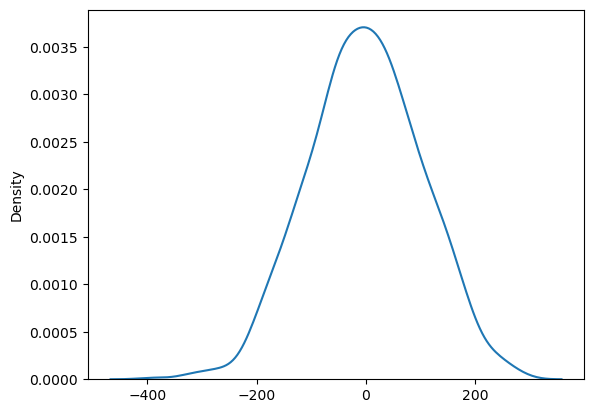

In [13]:
sns.kdeplot(np.random.normal(x_proj.iloc[0,:].mean(),x_proj.iloc[0,:].std(),1000))

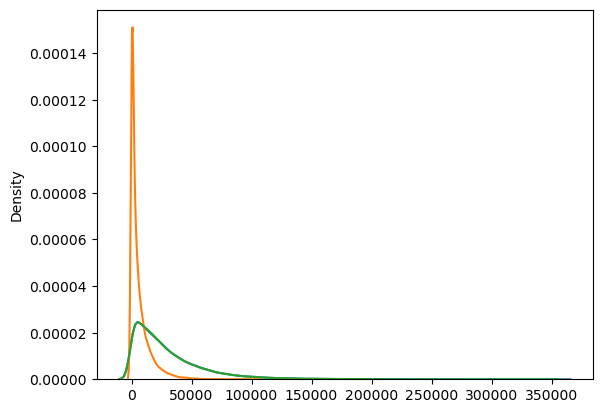

In [14]:
for i in [0,50,99]:
    sns.kdeplot(np.abs(xp_quantiles[i,:]-yp_quantiles[i,:])**2)

<Axes: ylabel='Density'>

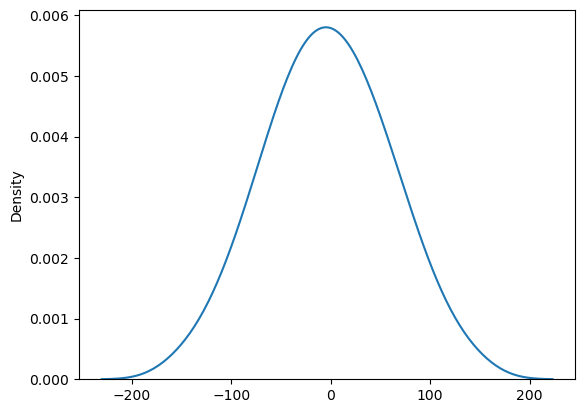

In [126]:
sns.kdeplot(xp_quantiles.mean(axis=1))

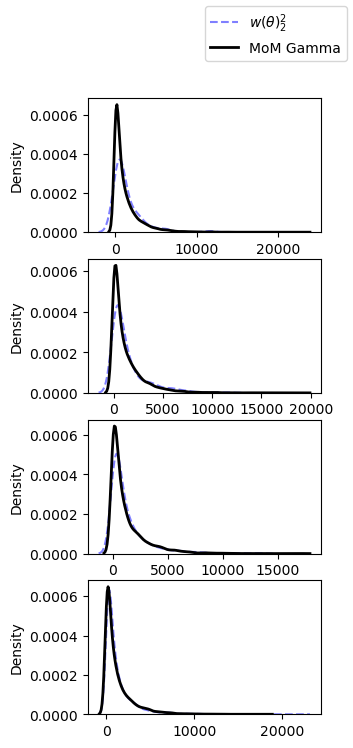

In [25]:


fig, ax = plt.subplots((4),figsize=(3,8))
col = 0
for N in [100,500,1000,5000]:
    THETA = sample_theta(X,N)
    w2 = project_and_calc_dist(X,Y,THETA,2).mean(axis=0)
    if N ==100:
        sns.kdeplot(w2,color='blue',alpha=0.5,ax=ax[col],label='$w(\\theta)_{2}^{2}$',ls='--')
    else:
        sns.kdeplot(w2,color='blue',alpha=0.5,ax=ax[col],ls='--')
    col+=1
a_hat, b_hat = mom_estimates(w2)
sns.kdeplot(np.random.gamma(a_hat,1/b_hat,10000),ax=ax[0],label='MoM Gamma',lw=2,color='black')

for col in range(1,4):
    sns.kdeplot(np.random.gamma(a_hat,1/b_hat,10000),ax=ax[col],lw=2,color='black')
fig.legend()
# THETA = sample_theta(X,1000)
# w2 = project_and_calc_dist(X,Y,THETA,2).mean(axis=0)

#a_hat, b_hat = mom_estimates(w2)

In [46]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


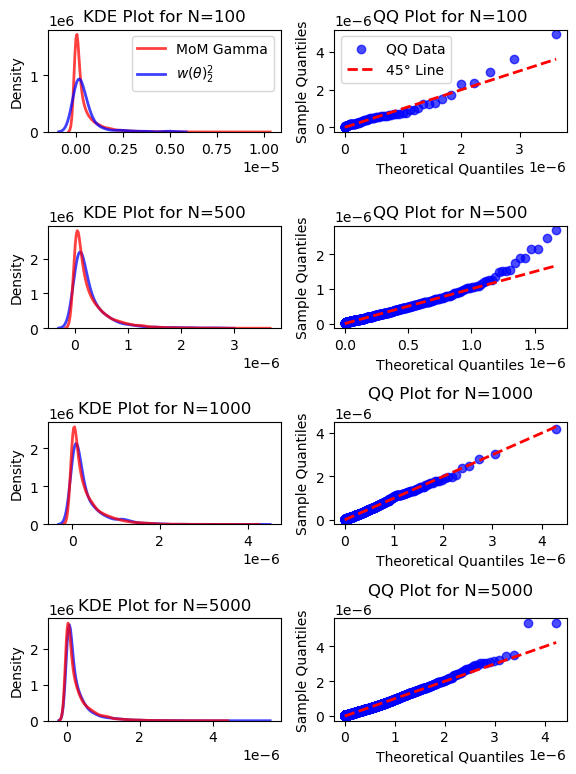

In [91]:
fig, ax = plt.subplots(4, 2, figsize=(6, 8))  # 4 rows, 2 columns
col = 0

for N in [100, 500, 1000, 5000]:
    # Sample theta and calculate w2
    THETA = sample_theta(X, N)
    w2 = project_and_calc_dist(X/255, Y/255, THETA, 2).mean(axis=0)
    # Estimate Gamma parameters
    a_hat, b_hat = mom_estimates(w2)
    
    # Left column: KDE plot
    if col == 0:
        sns.kdeplot(np.random.gamma(a_hat, 1 / b_hat, 10000), ax=ax[col, 0], alpha=0.75,lw=2, color='red', label='MoM Gamma')
        sns.kdeplot(w2, color='blue', ax=ax[col, 0], label='$w(\\theta)_{2}^{2}$',lw=2,alpha=0.75)
        ax[col,0].legend()
    else:
        sns.kdeplot(w2, color='blue', ax=ax[col, 0],lw=2,alpha=0.75)
        sns.kdeplot(np.random.gamma(a_hat, 1 / b_hat, 10000), ax=ax[col, 0], lw=2, color='red',alpha=0.75)
    ax[col, 0].set_title(f'KDE Plot for N={N}')
    
    # Right column: QQ plot
    # Sort empirical data
    w2_sorted = np.sort(w2)
    
    start_quantile = 0.001 if N >= 1000 else 0.01  # Smaller start for larger N
    end_quantile = 0.9999 if N >= 1000 else 0.99   # Larger end for larger N
    
    # Generate theoretical quantiles
    theoretical_quantiles = stats.gamma.ppf(
        np.linspace(start_quantile, end_quantile, len(w2_sorted)), a=a_hat, scale=1 / b_hat
    )
    
    # Plot QQ plot
    if col ==0:
        ax[col, 1].scatter(theoretical_quantiles, w2_sorted, alpha=0.7, label='QQ Data', color='blue')
        ax[col, 1].plot(theoretical_quantiles, theoretical_quantiles, color='red', linestyle='--', label='45° Line',lw=2)
        ax[col, 1].legend()
    else: 
        ax[col, 1].scatter(theoretical_quantiles, w2_sorted,alpha=0.7, color='blue')
        ax[col, 1].plot(theoretical_quantiles, theoretical_quantiles, color='red', linestyle='--',lw=2)
    ax[col, 1].set_title(f'QQ Plot for N={N}')
    ax[col, 1].set_xlabel("Theoretical Quantiles")
    ax[col, 1].set_ylabel("Sample Quantiles")

   


    
    col += 1

# Adjust layout and add legend
fig.tight_layout()
#fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=2)
plt.show()

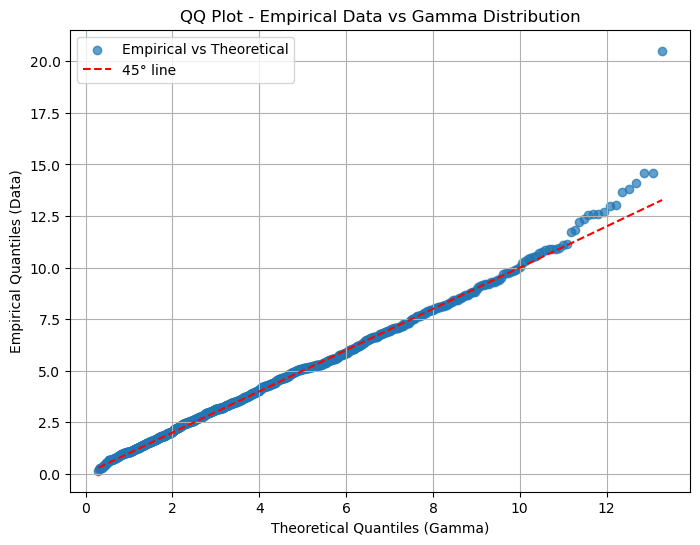

In [ ]:
import scipy.stats as stats


x = np.random.gamma(2, 2, 1000)  # Example data sampled from a Gamma distribution

# Gamma distribution parameters (shape and scale)
alpha = 2  # Shape parameter
beta = 2   # Scale parameter (inverse of rate)

# Sort the data
x_sorted = np.sort(x)

# Generate theoretical quantiles from the Gamma distribution
theoretical_quantiles = stats.gamma.ppf(
    np.linspace(0.01, 0.99, len(x_sorted)), a=alpha, scale=beta
)

# Plot the QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, x_sorted, label="Empirical vs Theoretical", alpha=0.7)
plt.plot(theoretical_quantiles, theoretical_quantiles, color="red", linestyle="--", label="45° line")

# Add labels and title
plt.title("QQ Plot - Empirical Data vs Gamma Distribution")
plt.xlabel("Theoretical Quantiles (Gamma)")
plt.ylabel("Empirical Quantiles (Data)")
plt.legend()
plt.grid()
plt.show()

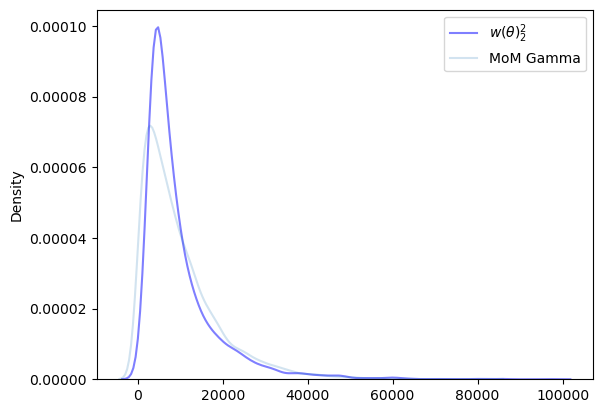

In [16]:
fig, ax = plt.subplots()
sns.kdeplot(w2,color='blue',alpha=0.5,ax=ax,label='$w(\\theta)_{2}^{2}$')
sns.kdeplot(np.random.gamma(a_hat,1/b_hat,10000),alpha=0.2,ax=ax,label='MoM Gamma')
ax.legend()